# Comparing the iterative method on Pegasus vs Zephyr Topology

Notebook to run the iterative method with the direct embedding fo MQ problems with $5$ and $9$ bits. The aim of this notebook is to analyze how the code runs on the new Zephyr topology compared to the now state-of-art Pegasus topology.

Reference: [Solving systems of Boolean multivariate equations with quantum annealing](https://arxiv.org/abs/2111.13224) by Sergi Ramos-Calderer, Carlos Bravo-Prieto, Ruge Lin, Emanuele Bellini, Marc Manzano, Najwa Aaraj, and José I. Latorre.

## Setup

In [1]:
# import
import my_lib as lib 
import article_lib as article

import examples_nnf as nnf

import numpy as np
import pandas as pd 
from sympy import symbols
from dwave.inspector import show

## MQ with $5$ bits

In [2]:
## problem parameters

bits = 5            # number of binary variables
iterations = 5      # number of iterations in iterative method
threshold = 10      # number of low energy solutions to check for the i.m.

In [3]:
## problem def

x5_sym = symbols(" ".join((f"x{i}" for i in range(1, bits+1))))
p5_sym, sol5 = nnf.example_5(*x5_sym)

In [4]:
## building symbolic H

direct = article.direct_embedding(bits, p5_sym, x5_sym)
H_sym = direct.create_hamiltonian()
sym = direct.get_symbols()
#print(H_sym)
#print(sym)

In [5]:
## building QUBO model

d_art = article.dwave_annealing(H_sym, bits, sym)
H_qubo, qubo_offset = d_art.symbolic_to_dwave(H_sym, d_art.get_symbol_num(sym))
#print(H_qubo)
#print(qubo_offset)

### Pegasus

Since with $5$ bits there is no need to run multiple iterations, we call the function `single_run`.

In [6]:
runner = lib.dwave_runners(H_qubo, qubo_offset, bits, 
                        topology='Pegasus', 
                        chosen_chainstrength='Article' )
p_response = runner.single_it()

Building the BQM model.


Running on Pegasus Topology.
You chose the Article chainstrength: 37.10526315789473.
Finished running the experiment!


In [7]:
solution = runner.decoding_response(p_response)
print(f'The solution found is one of the known solutions: {solution in sol5}')

Solution found: [1, 1, 0, 0, 1] with energy: 0.0
The solution found is one of the known solutions: True


Using the D-Wave `inspector` to visualize the results and the info:

In [8]:
show(p_response)

Serving Inspector on http://127.0.0.1:18000/?problemId=23cb6a81-c576-4cf1-8359-1f2bb5148746

'http://127.0.0.1:18000/?problemId=23cb6a81-c576-4cf1-8359-1f2bb5148746'

*Note*: the link associated to the inspector expires after a while and the output is not saved in the notebook. Therefore we report a screenshot of the output in the following markdown cell.

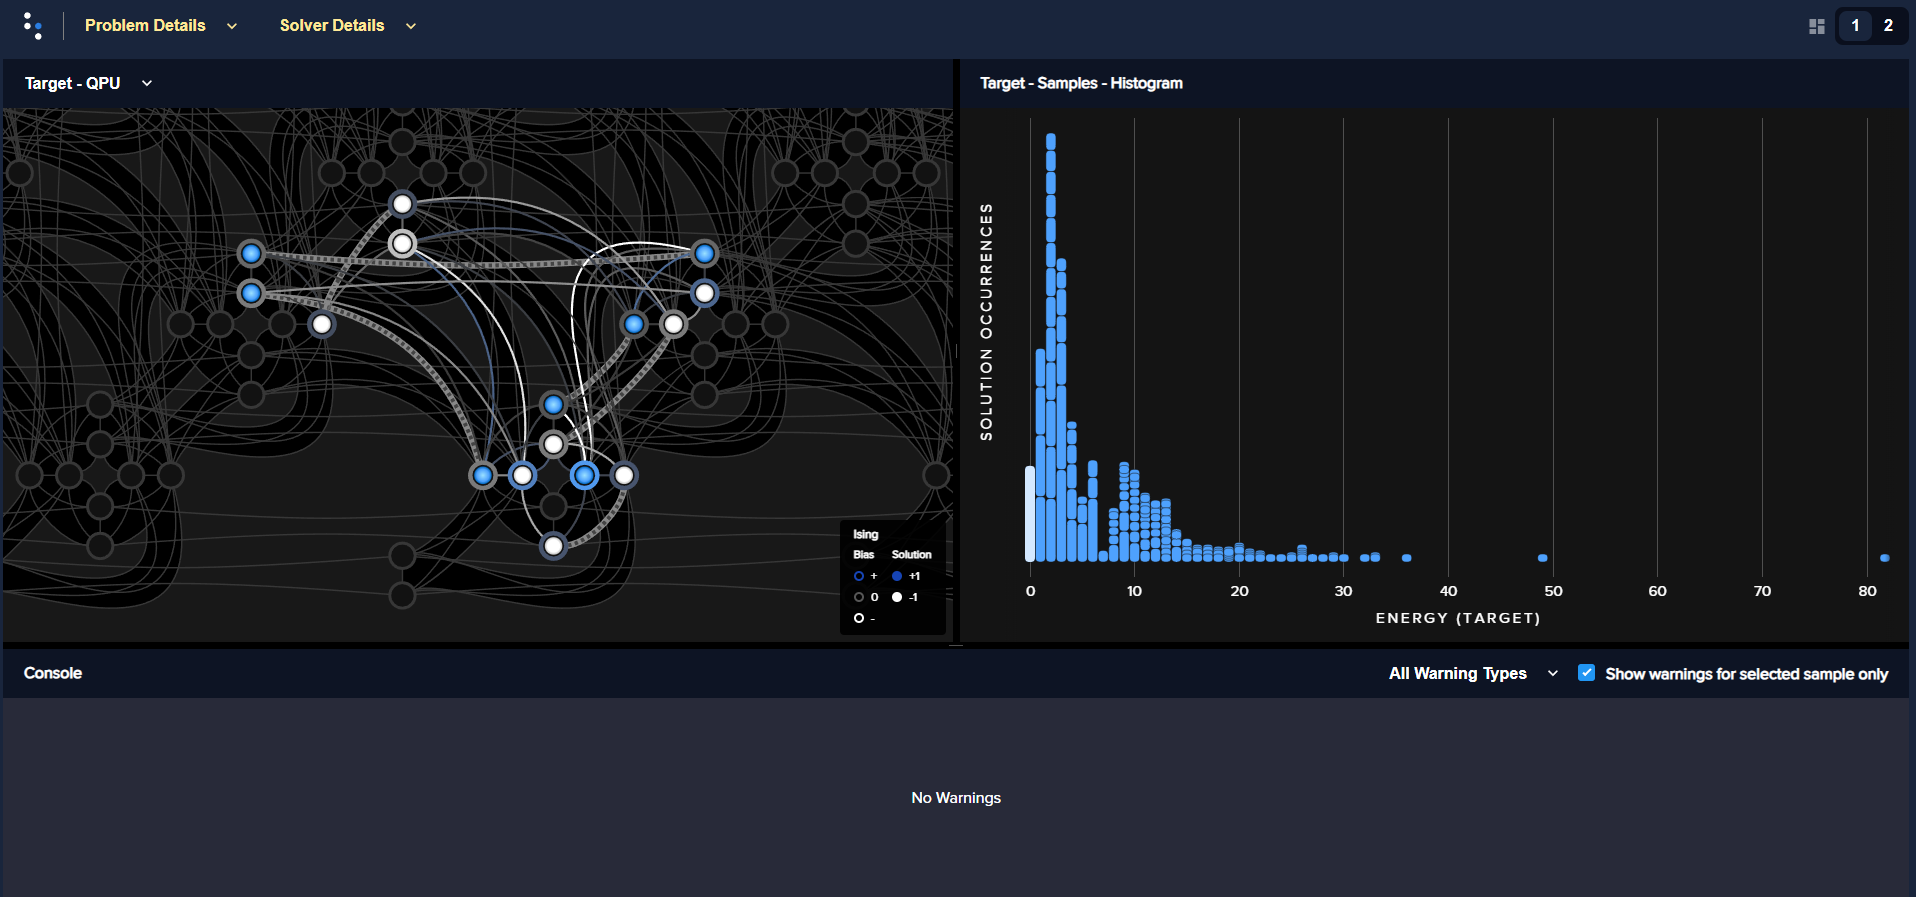

### Zephyr

In [9]:
runner = lib.dwave_runners(H_qubo, qubo_offset, bits, 
                        topology='Zephyr', 
                        chosen_chainstrength='Article' )
z_response = runner.single_it()

Building the BQM model.
Running on Zephyr Topology.
You chose the Article chainstrength: 37.10526315789473.
Finished running the experiment!


In [10]:
solution = runner.decoding_response(z_response)
print(f'The solution found is one of the known solutions: {solution in sol5}')

Solution found: [1, 1, 0, 0, 1] with energy: 0.0
The solution found is one of the known solutions: True


In [11]:
show(z_response)

Serving Inspector on http://127.0.0.1:18000/?problemId=3e31771f-da73-4a89-824f-3283eb0e268c

'http://127.0.0.1:18000/?problemId=3e31771f-da73-4a89-824f-3283eb0e268c'

*Note*: the link associated to the inspector expires after a while and the output is not saved in the notebook. Therefore we report a screenshot of the output in the following markdown cell.

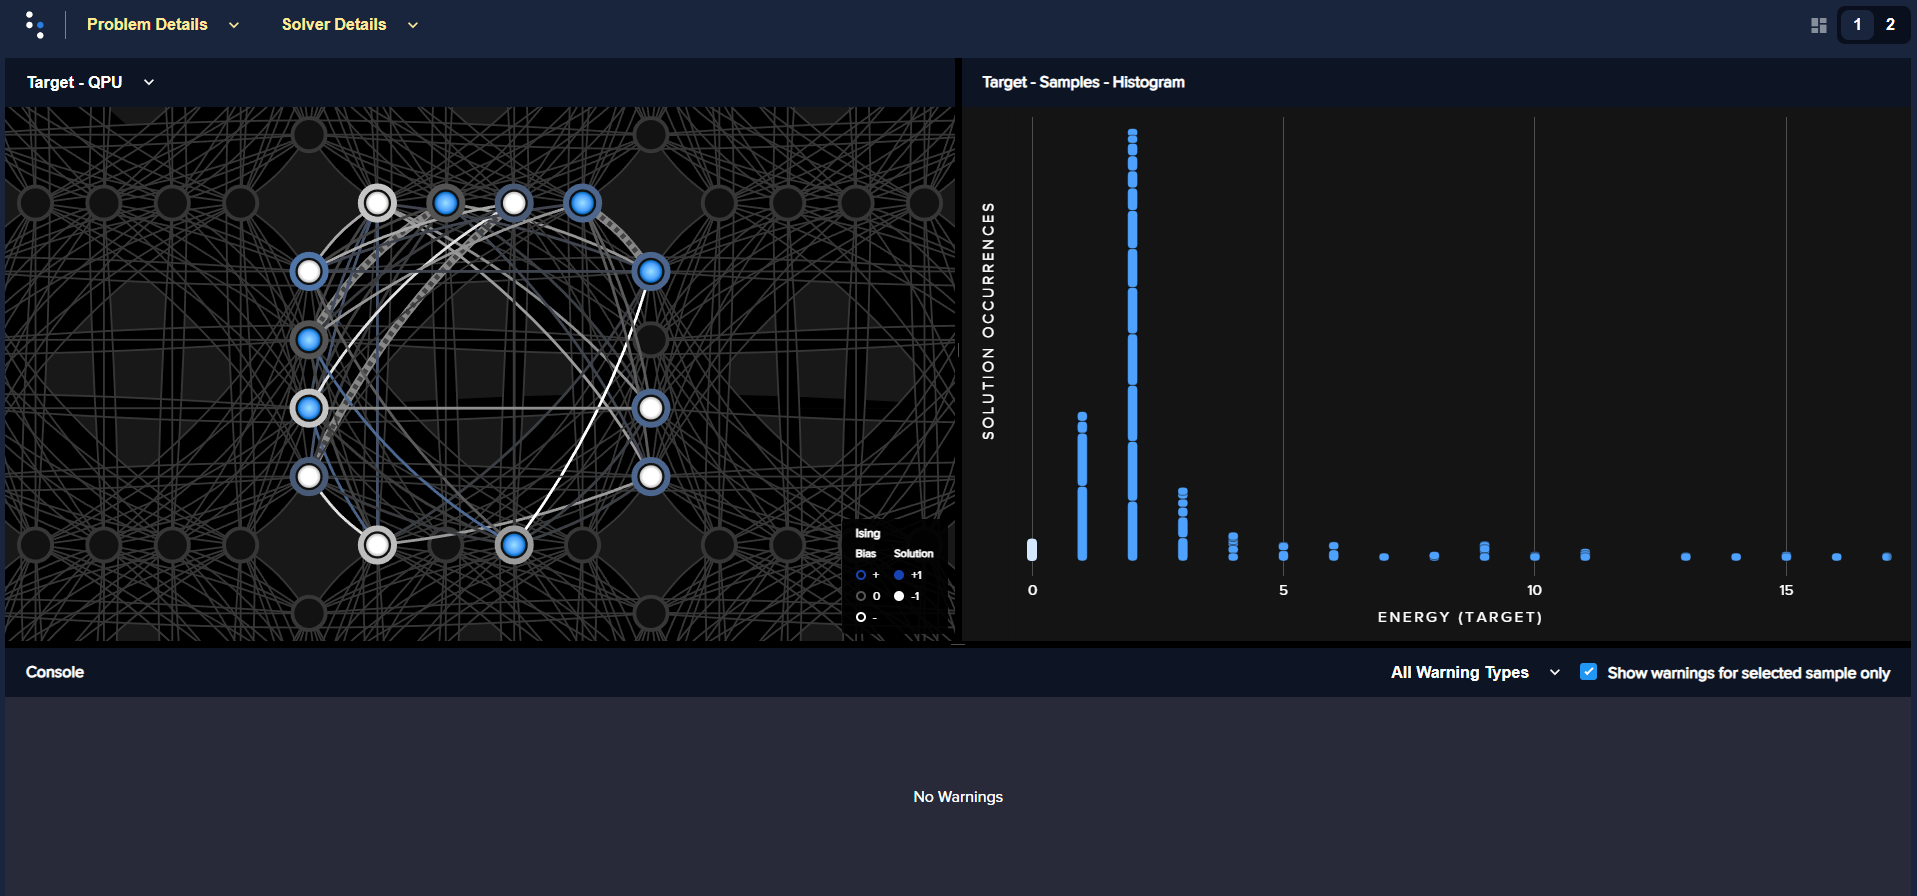

### Analysis

Let's compare the informations on the runs on the two topologies:

In [12]:
## pegasus info
pegasus_timing = p_response.info['timing']
pegasus_embedding = p_response.info['embedding_context']['embedding']

## zephyr info
zephyr_timing = z_response.info['timing']
zephyr_embedding = z_response.info['embedding_context']['embedding']

In [18]:
## comparing timing data from the runs

diff = []
for key in zephyr_timing:
    diff.append(zephyr_timing[key] - pegasus_timing[key])

data = {'Zephyr': zephyr_timing.values(),
        'Pegasus': pegasus_timing.values(),
        'Differences': diff}

timings_df = pd.DataFrame(data, index = zephyr_timing.keys())
print('\033[1m' + '-----------Difference in timings (Zephyr vs Pegasus)-----------' + '\033[0m')
print(timings_df)

-----------Difference in timings (Zephyr vs Pegasus)-----------
                                 Zephyr    Pegasus  Differences
qpu_sampling_time              79000.00   98740.00    -19740.00
qpu_anneal_time_per_sample        20.00      20.00         0.00
qpu_readout_time_per_sample       38.45      58.20       -19.75
qpu_access_time                98227.21  114667.97    -16440.76
qpu_access_overhead_time        1030.79    1388.03      -357.24
qpu_programming_time           19227.21   15927.97      3299.24
qpu_delay_time_per_sample         20.55      20.54         0.01
post_processing_overhead_time      1.00       1.00         0.00
total_post_processing_time         1.00       1.00         0.00


In [15]:
## comparing embedding data from the runs

z_count, z_chains = runner.get_info_on_embedding(zephyr_embedding)
p_count, p_chains = runner.get_info_on_embedding(pegasus_embedding)

In [16]:
print(f'The run on the Zephyr topology required {z_count} physical qubits.')
print(f'The run on the Pegasus topology required {p_count} physical qubits.\n')

data = {'Zephyr': z_chains,
        'Pegasus': p_chains}
chains_df = pd.DataFrame(data, index = z_chains.keys()).transpose()
print('\033[1m' + '-------------Difference in embeddings (Zephyr vs Pegasus)-------------' + '\033[0m')
print(chains_df)

The run on the Zephyr topology required 13 physical qubits.
The run on the Pegasus topology required 16 physical qubits.

-------------Difference in embeddings (Zephyr vs Pegasus)-------------
         lq_0  lq_1  lq_2  lq_3  lq_4  lq_5  lq_6  lq_7  lq_8  lq_9
Zephyr      2     1     1     1     1     2     2     1     1     1
Pegasus     2     2     2     1     2     1     1     2     2     1


## MQ with $9$ bits

In [2]:
## problem parameters

bits = 9            # number of binary variables
iterations = 5      # number of iterations in iterative method
threshold = 10       # number of low energy solutions to check for the i.m.

In [3]:
## problem def

x9_sym = symbols(" ".join((f"x{i}" for i in range(1, bits+1))))
p9_sym, sol9 = nnf.example_9(*x9_sym)

In [4]:
## building symbolic H

direct = article.direct_embedding(bits, p9_sym, x9_sym)
H_sym = direct.create_hamiltonian()
sym = direct.get_symbols()
#print(H_sym)
print(sym)

(x1, x2, x3, x4, x5, x6, x7, x8, x9, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23, a24, a25, a26, a27, a28, a29, a30, a31, a32, a33, a34, a35, a36, a37)


In [5]:
## building QUBO model

d_art = article.dwave_annealing(H_sym, bits, sym)
H_qubo, qubo_offset = d_art.symbolic_to_dwave(H_sym, d_art.get_symbol_num(sym))
#print(H_qubo)
#print(qubo_offset)

### Pegasus

Here, we need the iterative method.

In [6]:
runner = lib.dwave_runners(H_qubo, qubo_offset, bits, 'Pegasus', 'Article')
print('\n------------------------------------------------------------------------\n')
p_solution, p_timing_info, p_physical_qubits, p_final_it = runner.iterative(iterations=5)

Building the BQM model.
Running on Pegasus Topology.

------------------------------------------------------------------------

Number of variables: 46
You chose the Article chainstrength: 217.7682481751825.
Finished running the experiment!
Energy of best sample at iteration 0: 40.0


Serving Inspector on http://127.0.0.1:18000/?problemId=82570ef6-f247-42e8-b5f3-04acc7679ec1

Fixing ancillae...
Fixed 11 qubits:
11 : 0
12 : 0
14 : 0
16 : 0
18 : 0
28 : 0
35 : 0
37 : 0
38 : 0
39 : 0
41 : 0

------------------------------------------------------------------------

Number of variables: 35
You chose the Article chainstrength: 258.62006079027356.
Finished running the experiment!
Energy of best sample at iteration 1: 1.0
Fixing ancillae...
Fixed 17 qubits:
11 : 0
12 : 0
14 : 0
16 : 0
18 : 0
28 : 0
35 : 0
37 : 0
38 : 0
39 : 0
41 : 0
19 : 0
20 : 0
22 : 0
23 : 0
25 : 0
26 : 0

------------------------------------------------------------------------

Number of variables: 29
You chose the Article chainstrength: 280.706106870229.
Finished running the experiment!
Energy of best sample at iteration 2: 0.0
Solution found with final iteration 2.
Reconstructing the final state...
Solution found: [1, 0, 0, 1, 0, 1, 0, 1, 1]


### Zephyr

In [7]:
runner = lib.dwave_runners(H_qubo, qubo_offset, bits, 'Zephyr', 'Article')
print('\n------------------------------------------------------------------------\n')
z_solution, z_timing_info, z_physical_qubits, z_final_it = runner.iterative(iterations=5)

Building the BQM model.
Running on Zephyr Topology.

------------------------------------------------------------------------

Number of variables: 46
You chose the Article chainstrength: 217.7682481751825.
Finished running the experiment!
Energy of best sample at iteration 0: 0.0


Serving Inspector on http://127.0.0.1:18000/?problemId=62cd3276-c816-43cc-a166-2459c0153628

Solution found with final iteration 0.
Reconstructing the final state...
Solution found: [0, 0, 0, 1, 1, 0, 1, 1, 0]


### Analysis

First embedding on Pegasus topology:

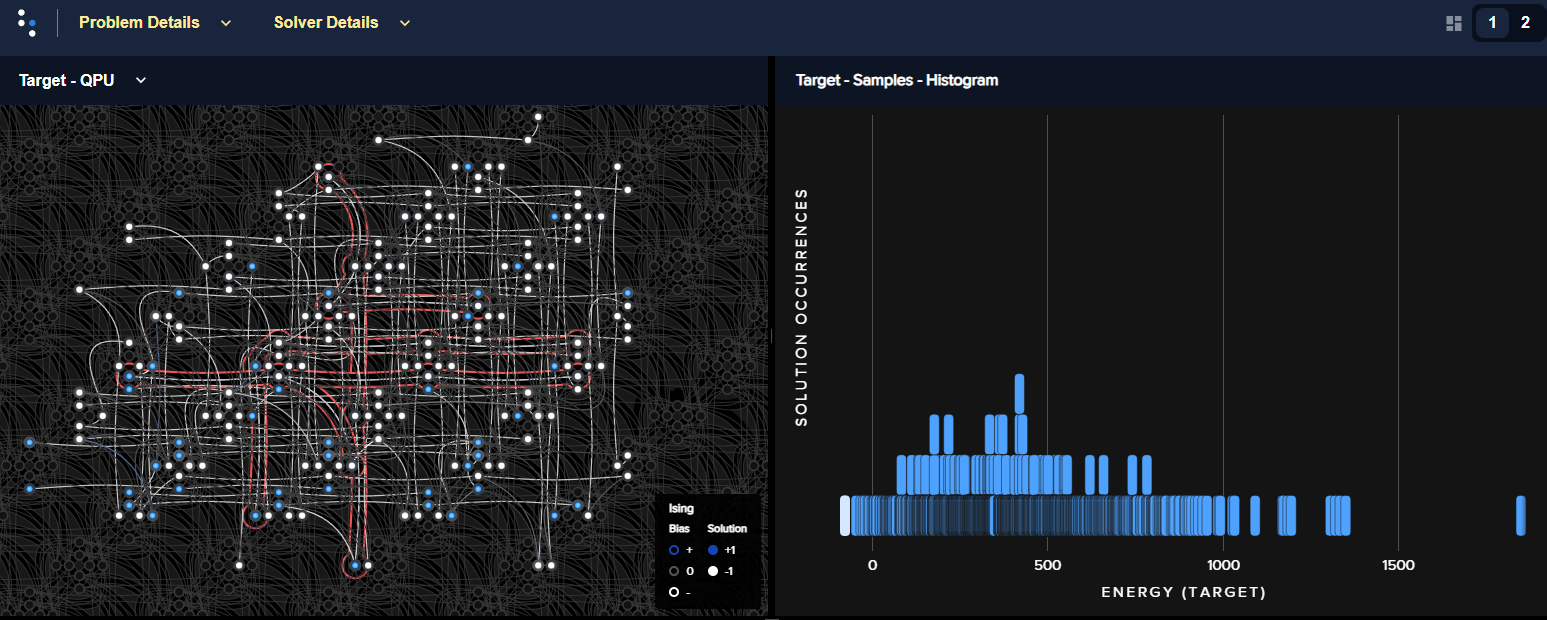

First embedding on Zephyr topology:

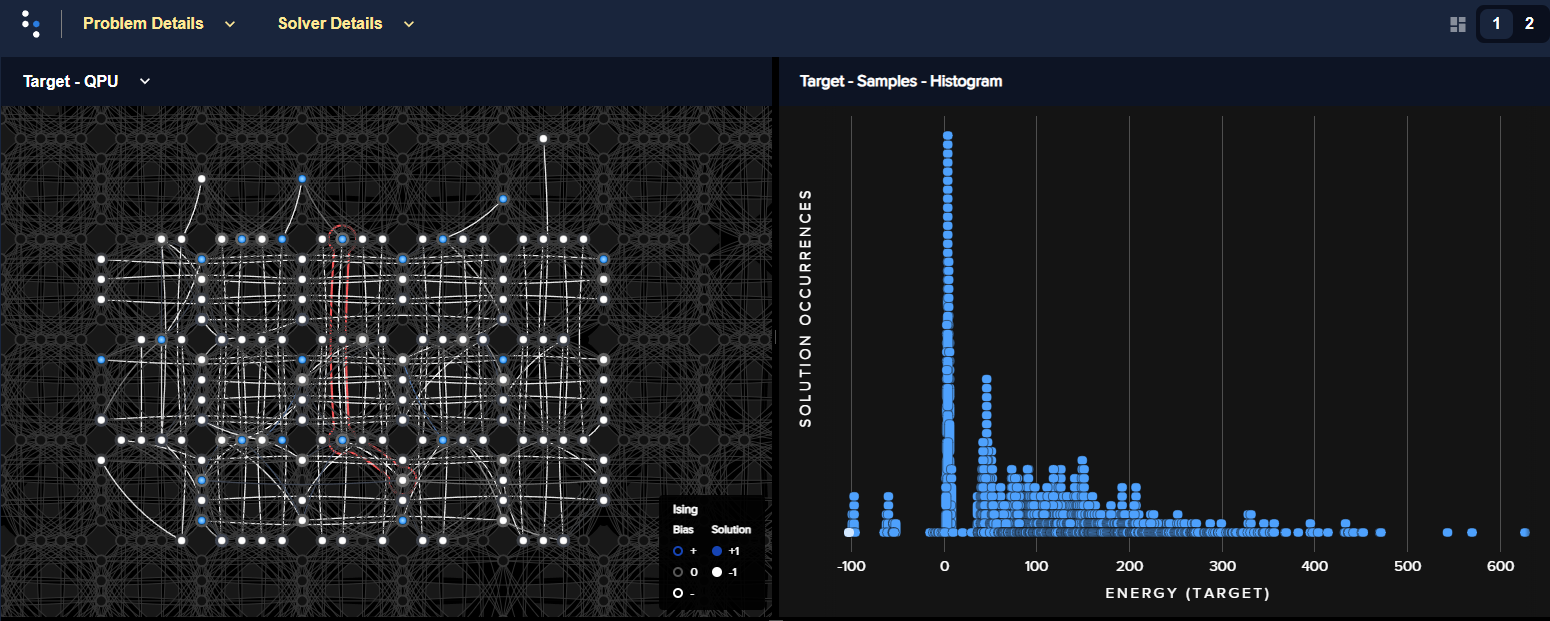

*Note*: red lines are the chains that broke in that sample.

In [8]:
print(f'The iterative method on the Zephyr topology required a total of {z_physical_qubits} physical qubits for {z_final_it+1} iterations.')
print(f'It found a solution: {z_solution in sol9}.\n')

print(f'The iterative method on the Pegasus topology required a total of {p_physical_qubits} physical qubits for {p_final_it+1} iterations.')
print(f'It found a solution: {p_solution in sol9}.')

The iterative method on the Zephyr topology required a total of 135 physical qubits for 1 iterations.
It found a solution: True.

The iterative method on the Pegasus topology required a total of 391 physical qubits for 3 iterations.
It found a solution: True.


In [9]:
## comparing timing data
## this is only useful when both iteratives
## end within the same number of iterations

for key in z_timing_info.keys():
    z_timing_info[key] = z_timing_info[key]/(z_final_it+1)
    p_timing_info[key] = p_timing_info[key]/(p_final_it+1)

diff_iterative = []
for key in z_timing_info:
    diff_iterative.append(z_timing_info[key] - p_timing_info[key])

data = {'Zephyr': z_timing_info.values(),
        'Pegasus': p_timing_info.values(),
        'Difference': diff_iterative}

In [ ]:
iterative_timings_df = pd.DataFrame(data, index = z_timing_info.keys())
print('\033[1m' + '-------------Difference in timings (Zephyr vs Pegasus)-------------' + '\033[0m')
print(iterative_timings_df)